In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import numpy as np
from drone_sac import AgentParallel3layers, BufferParallel
from drone_gym import DroneGym
from tqdm.notebook import tqdm
import torch as T
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: easyvec.vectors.Vec3 size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject


In [2]:
from distributed import Client, LocalCluster

n_workers  = 17
cl = Client(LocalCluster(n_workers=n_workers, threads_per_worker=1))
cl

Client Scheduler: tcp://127.0.0.1:16019 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 17 Cores: 17 Memory: 63.93 GiB


In [27]:
def generate_data(agent_dict, n_points):
    try:
        import sys
        sys.path.append(r'D:\neuro_missile\src\cydrone')
        sys.path.append(r'D:\neuro_missile\src\drone_1_3sr')
        import numpy as np
        from drone_sac import AgentParallel3layers, BufferParallel
        from drone_gym import DroneGym
        
#         import pickle
#         with open('agent_dict.bin', 'rb') as f:
#             agent_dict = pickle.load(f)
        
        env = DroneGym.make()
        agent = AgentParallel3layers(
            input_dims=env.obs_max.shape, 
            n_actions=2, 
            action_space_high=env.action_space.high,
            device_name='cpu')
        agent.from_dict(agent_dict)
        buffer = BufferParallel(agent)

        env.record_history = False
        env.antiflip = False
        n = 0
        while n < n_points:
            observation = env.reset()
            done = False
            while not done:
                action = agent.choose_action(observation)
#                 action = np.random.uniform(0.97,1, size=2)
                observation_, reward, done, info = env.step(action)
                buffer.store_transition(observation, action, reward, observation_, done)
                observation = observation_
                n += 1
                if n >= n_points*10:
                    return True, buffer.to_dict(), info
        return True, buffer.to_dict(), info
    except Exception as e:
        return False, {'error': str(e)}

In [9]:
env = DroneGym.make()
agent = AgentParallel3layers(input_dims=env.obs_max.shape, n_actions=2, action_space_high=env.action_space.high)
buffer = BufferParallel(agent)

# import pickle
# with open('agent_dict.bin', 'rb') as f:
#     agent_dict = pickle.load(f)
# agent.from_dict(agent_dict)

In [28]:
def run_parallel_sim(n):
    d = agent.to_dict()
    dicts_futs = cl.scatter([d] * n_workers)
    n_pointss = [n] * n_workers
    futs = cl.map(generate_data, dicts_futs, n_pointss, pure=False)
    return futs 

def run_parallel_sim_file(n):
    import pickle
    with open('agent_dict.bin', 'wb') as f:
        pickle.dump(agent.to_dict(), f)
    n_pointss = [n] * n_workers
    futs = cl.map(generate_data_file, n_pointss, pure=False)
    return futs 

def extend_buff(futs):
    results = cl.gather(futs)
    for suc, points, info in results:
        infos.append(info)
        if suc:
            buffer.extend_from_dict(points)
            
def learn(batch_size, refresh=True):
    if refresh:
        buffer.refresh()
    losses = []
    for batch in buffer.iter_batches(batch_size):
        losses.append(agent.learn(*batch))
    return np.mean(losses, axis=0)

def plot_losses(ax_value, ax_actor, ax_critic, losses):
    ax_value.plot([val for val, act, crit in losses])
    ax_actor.plot([act for val, act, crit in losses])
    ax_critic.plot([crit for val, act, crit in losses])
    
    ax_value.grid()
    ax_actor.grid()
    ax_critic.grid()

In [29]:
infos = []

In [12]:
buffer = BufferParallel(agent)

In [13]:
futs = run_parallel_sim(3000)
extend_buff(futs)
learn(256)

array([ 10.22024 ,  19.306265, 371.42194 ], dtype=float32)

In [14]:
losses = []

In [30]:
for i in tqdm(range(1400)):
    futs = run_parallel_sim(5000)
    buffer.refresh()
    first = True
    while not all([f.status in {'finished', 'error'} for f in futs]) or first:
        first = False
        alpha,beta=np.random.uniform(0.00001, 0.0003, size=2)
        agent.change_lr(alpha=alpha, beta=beta)
        losses.append(learn(1024*2, False))
    extend_buff(futs)   
    buffer.trim_oldest(1500000, False)
buffer.refresh()

  0%|          | 0/1400 [00:00<?, ?it/s]

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


KeyboardInterrupt: 

In [38]:
alpha=np.random.uniform(0.00001, 0.0003)
agent.change_lr(alpha=alpha, beta=alpha)

In [38]:
buffer.refresh()

1500000

In [11]:
for i in tqdm(range(30)):
    losses.append(learn(512, False))

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

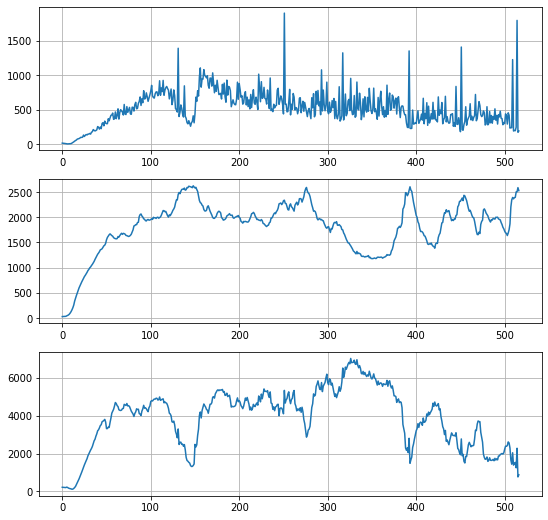

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(9,9))
plot_losses(ax1, ax2, ax3, losses[:])
plt.show()

In [68]:
successes = [i for i in infos if 'result' in i and i['result'] == 'success']
len(successes)/len(infos)

0.7011795543905636

In [45]:
[i for i in infos if 'result' in i and i['result'] != 'success']

[{'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'result': 'out of Y bounds'},
 {'resul

In [46]:
final_rewards = [i['final_reward'] for i in successes]
max(final_rewards), min(final_rewards), np.mean(final_rewards)

(22.150455800597452, -12.843475206819512, 10.17548901137921)

In [54]:
import pickle
# with open('agent_dict.bin', 'rb') as f:
#     agent_dict = pickle.load(f)
# agent.from_dict(agent_dict)

with open('agent_dict.bin', 'wb') as f:
    pickle.dump(agent.to_dict(), f)

In [33]:
env = DroneGym.make()

In [48]:
score = 0
env.record_history = True
env.antiflip = False
for i in tqdm(range(1)):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = np.random.uniform(0.6,1, size=2)
        action[1] = np.random.uniform(-0.5,0.5)
        action = agent.choose_action_determ(observation)
#         action[0] *= 2
        observation_, reward, done, info = env.step(action)
        score += reward
        buffer.store_transition(observation, action, reward, observation_, done)
        observation = observation_
#     buffer.refresh()
#     for batch in buffer.iter_batches(2048):
#         agent.learn(*batch)

  0%|          | 0/1 [00:00<?, ?it/s]

In [49]:
info

{'result': 'success',
 'final_reward': 5.9680401247484,
 'pos_diff': 0.89688764815875,
 'dir_diff': 0.7974846374022619,
 'vel_diff': 4.28004922372327}

In [50]:
buffer.refresh()

1504384

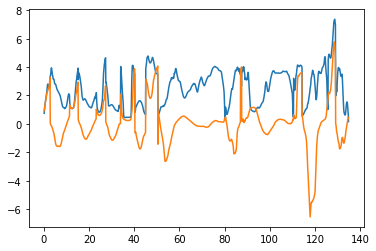

In [51]:
from ipywidgets import interact, interactive, fixed
import ipywidgets
import matplotlib.pyplot as plt
gym = env

xs = []
ys = []
f1s = []
f2s = []
rewards = []
ts = []
dts = []
scores = [0]
vels = []
for d in gym.history:
    gym.set_state(d['state'])
    xs.append(gym.drone.pos.x)
    ys.append(gym.drone.pos.y)
    f1, f2 = d['actions']
    f1s.append(f1)
    f2s.append(f2)
    ts.append(gym.time_curr)
    rewards.append(d['reward'])
    dts.append(d['delta_t1'])
    scores.append(scores[-1]+d['reward'])
    vels.append(gym.drone.vel.len())
scores = scores[1:]
i1=0
i2=-1
# plt.plot(ts[i1:i2], rewards[i1:i2])
plt.plot(ts[i1:i2], f1s[i1:i2])
plt.plot(ts[i1:i2], f2s[i1:i2])
# plt.plot(ts[i1:i2], dts[i1:i2])

In [52]:
@interact(i=ipywidgets.IntSlider(min=0,max=len(gym.history)-1,step=1, value=0))
def plot_history(i):
    d = gym.history[i]
    i1=0#max(0,i-30)
    i2=i+1
    gym.set_state(d['state'])
    fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(14,7))
    gym.plot(ax, drone_mashtb=20, vec_mashtb=1, actions=d['actions'],ideal_traj=True)
    ax.plot(xs[i1:i],ys[i1:i],ls=':')
    ax.set_aspect('equal', adjustable='box')
    
    
#     ax2.plot(ts[i1:i2], f1s[i1:i2])
#     ax2.plot(ts[i1:i2], f2s[i1:i2])
    ax2.grid()
    ax2.plot(ts[:i2], vels[:i2])
    
    ax3.plot(ts[:i2], rewards[:i2])
    ax3.grid()
    ax.grid()
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=1349), Output()), _dom_classes=('widget-interact…

In [37]:
info

{'result': 'out of Y bounds'}

In [53]:
gym.vel_trg

Vec2(-2.65498548924246, 5.082398894395873)